### 0. Inital package import

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from scipy import stats
import json

# 1. Movie dataset preprocessing


### 1.1 Movie dataset import

In [64]:
movies_column_names = ['Wikipedia_movie_ID','Freebase_movie_ID','Movie_name','Movie_release_date','Movie_box_office_revenue','Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
movies = pd.read_csv('..\data\movie.metadata.tsv', sep='\t', header=None,names=movies_column_names, decimal='.' )
movies.Movie_release_date = pd.to_datetime(movies.Movie_release_date,format='mixed', errors='coerce', utc=True)
print(len(movies))

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\mirco\AppData\Local\Temp\ipykernel_15848\3090806636.py:2: SyntaxWarning: invalid escape sequence '\d'
  movies = pd.read_csv('..\data\movie.metadata.tsv', sep='\t', header=None,names=movies_column_names, decimal='.' )


81741


### 1.2 Preprocessing and analysis on movies country of origin and language

#### 1.2.1 Study of dataset country and language

A first step would be to see how much language and country per movies do we have, can we have only one language per movies ?

In [65]:
# Define the functions
def nb_items(vardict):
    # Extract ids and count them to get the number of items
    id = [id for id, name in eval(vardict).items()]
    return len(id)

def list_name(vardict):
    # Extract names
    name = [name.replace("Language", "language").replace("language", "") for id, name in eval(vardict).items()]
    return name if name else None

# Calculate the number of languages and countries for each movie
movies["nb_languages"] = movies['Movie_languages'].apply(nb_items)
movies["nb_country"] = movies['Movie_countries'].apply(nb_items)
movies["nb_genre"] = movies['Movie_genres'].apply(nb_items)

# Extract the list of languages and countries directly
movies["Movie_language"] = movies['Movie_languages'].apply(list_name)
movies["Movie_countries"] = movies['Movie_countries'].apply(list_name)
movies["Movie_genres"] = movies['Movie_genres'].apply(list_name)


#### Describing how many language and country the movies of the dataset have 

In [66]:
movies["nb_languages"].describe()

count    81741.000000
mean         0.994678
std          0.690623
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         15.000000
Name: nb_languages, dtype: float64

In [67]:
movies["nb_country"].describe()

count    81741.000000
mean         1.057474
std          0.623572
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         14.000000
Name: nb_country, dtype: float64

Text(0.5, 0, 'Number of countries or languages')

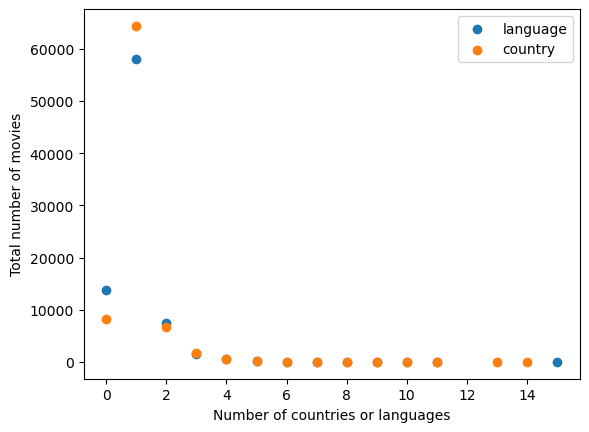

In [68]:
# If we focus on the occurence of each number of language and movies 
total_languages = movies.groupby("nb_languages")["nb_languages"].agg("count")
total_country = movies.groupby("nb_country")["nb_languages"].agg("count")

plt.figure()
plt.scatter(total_languages.index,total_languages.values, label = "language" )
plt.scatter(total_country.index,total_country, label = "country" )
plt.legend()
plt.ylabel("Total number of movies")
plt.xlabel("Number of countries or languages")

From the description and the plot of the total number of movies per number of languages and countries, it appears that the two variables have similar distributions in terms of total counts. However, do they have a similar distribution at the individual movie level? In other words, does a movie associated with 3 countries typically also have 3 languages? 

In [69]:
# statistical study
stats.spearmanr(movies["nb_languages"], movies["nb_country"])

SignificanceResult(statistic=0.37307077954108103, pvalue=0.0)

The two variables seems to be moderatly to low correlated with a high confidence as it is seen with the p-value, thus there is a tendensy of increase of language per movies with the increase of number of countries but the correlation is not that strong

#### 1.2.2 Treating outliers

Now that we have studied this, how should we handle outliers? To address this, we can keep only the movies where the number of countries and the number of languages fall between the 5th and 95th percentiles

In [70]:

quantile_5 = np.quantile(movies.nb_languages, 0.05)
quantile_95 = np.quantile(movies.nb_languages, 0.95)

print(f"For language we will keep movies have a number of languages between the 5% percentiles {quantile_5} languages and the 95% percentiles {quantile_95} languages")

For language we will keep movies have a number of languages between the 5% percentiles 0.0 languages and the 95% percentiles 2.0 languages


In [71]:

quantile_5 = np.quantile(movies.nb_country, 0.05)
quantile_95 = np.quantile(movies.nb_country, 0.95)
print(f"For country we will keep movies have a number of countries between the 5% percentiles {quantile_5} countries and the 95% percentiles {quantile_95} countries")

For country we will keep movies have a number of countries between the 5% percentiles 0.0 countries and the 95% percentiles 2.0 countries


#### 1.2.3 Movies with more than 2 languages 

Lets focus a bit more on the movies out of the range 95 quantile, do they have something in common

In [72]:
movies_language_high = movies.loc[movies.nb_languages>2]
print(f"There is {len(movies_language_high)} with more than 2 languages")

There is 2319 with more than 2 languages


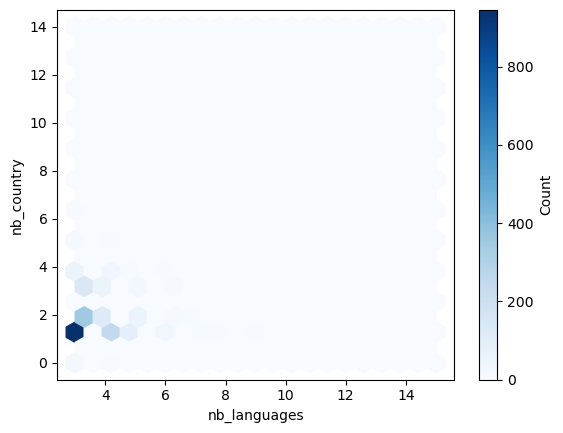

In [73]:


movies_language_high[["nb_languages","nb_country"]]

plt.hexbin(movies_language_high.nb_languages, movies_language_high.nb_country, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_languages')
plt.ylabel('nb_country')
plt.show()

In [74]:
movies_language_high.groupby("nb_country")["nb_country"].agg("count")

nb_country
0       29
1     1336
2      555
3      241
4      104
5       28
6       13
7        8
8        2
9        2
14       1
Name: nb_country, dtype: int64

We notice here that the majority of movies with more than 2 languages have actually 1 or 2 countries, we can than associate to these movies the language associated to the country they belong to.
To do this, we need to have for each country one main language, we will get this from the movies with 1 country and 1 language

In [75]:
country_language_all = movies.loc[(movies.nb_languages == 1) & (movies.nb_country == 1)].copy()
country_language_all["Movie_language"] = country_language_all["Movie_language"].apply(lambda x: x[0])
country_language_all["Movie_countries"] = country_language_all["Movie_countries"].apply(lambda x: x[0])
country_language_all = country_language_all.groupby(["Movie_language","Movie_countries"])["Movie_name"].agg("count").sort_values(ascending = False).reset_index()


In [76]:
# we keep the couple (language, movie) with the highest occurence
country_language_unique = country_language_all.drop_duplicates(subset=['Movie_countries'], keep='first')
country_language_unique = country_language_unique.reset_index(drop=True)

print(country_language_unique)

    Movie_language           Movie_countries  Movie_name
0         English   United States of America       23431
1         English             United Kingdom        4079
2           Hindi                      India        2865
3        Japanese                      Japan        1684
4         Italian                      Italy        1392
..             ...                       ...         ...
114        Arabic                      Libya           1
115    Macedonian      Republic of Macedonia           1
116     Malayalam                 Malayalam            1
117     Mongolian                   Mongolia           1
118       Italian                     Cyprus           1

[119 rows x 3 columns]


Now that we have this link, we can assign one or two main languages to a movie based on its country. If the movie has a language that appears in the list of languages associated with a country, and the list contains more than two languages, and the movie is associated with one or two countries, we can extract those languages as the main language. We will apply this logic to famous movies that feature multiple languages.

In [77]:
movies_language_high.loc[movies_language_high['nb_country'] == 1, 'Movie_language']= \
    movies_language_high.loc[movies_language_high['nb_country'] == 1, 'Movie_countries'].copy().apply(
    lambda x: country_language_unique.loc[country_language_unique['Movie_countries'] == x[0],'Movie_language'].values)

movies_language_high.loc[movies_language_high['nb_country'] == 2, 'Movie_language'] = \
    movies_language_high.loc[movies_language_high['nb_country'] == 2, 'Movie_countries'].apply(
        lambda x: country_language_unique.loc[
            (country_language_unique['Movie_countries'] == x[0]) | 
            (country_language_unique['Movie_countries'] == x[1]),
            'Movie_language'
        ].values)

movies_language_high.loc[:, "Movie_language"] = movies_language_high["Movie_language"].apply(lambda x: np.unique(x))


movies_language_high.sort_values(by = ["Movie_box_office_revenue"], ascending = False)[["Movie_name", "nb_languages","Movie_countries","Movie_language"]][:20]

,Movie_name,nb_languages,Movie_countries,Movie_language
22256,Titanic,6,[United States of America],[English ]
21432,The Lion King,4,[United States of America],[English ]
10820,Harry Potter and the Goblet of Fire,3,"[United States of America, United Kingdom]",[English ]
60260,Inception,3,"[United States of America, United Kingdom]",[English ]
33405,Indiana Jones and the Kingdom of the Crystal S...,3,[United States of America],[English ]
14453,Spider-Man 2,3,[United States of America],[English ]
53055,2012,9,[United States of America],[English ]
23863,The Da Vinci Code,4,[United States of America],[English ]
19034,The Incredibles,3,[United States of America],[English ]
64107,Fast Five,3,[United States of America],[English ]


In [78]:
movies.loc[movies.nb_languages>2] = movies_language_high

# lets upddate the nb of languages
movies.loc[movies.nb_languages>2, "nb_languages"] = movies.loc[movies.nb_languages>2, 'Movie_language'].apply(lambda x: len(x))
print(len(movies.loc[movies.nb_languages>2]))

428


using this, we go from 2319 movies with more than 2 languages to 428 movies 

#### 1.2.4 Movies with more than 2 countries

In [79]:
movies_country_high = movies.loc[movies.nb_country>2]
print(f"There is {len(movies_country_high)} with more than 2 countries")

There is 2500 with more than 2 countries


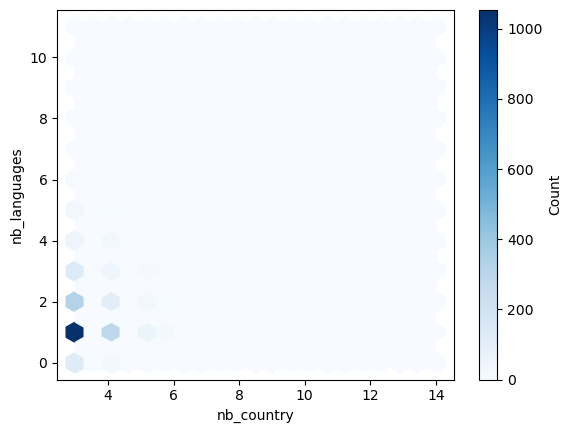

In [80]:
movies_country_high[["nb_languages","nb_country"]]

plt.hexbin(movies_country_high.nb_country,movies_country_high.nb_languages, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_country')
plt.ylabel('nb_languages')
plt.show()

In [81]:
movies_country_high.groupby("nb_languages")["nb_languages"].agg("count")

nb_languages
0      167
1     1447
2      487
3      217
4      102
5       46
6       23
7        5
8        3
9        1
11       2
Name: nb_languages, dtype: int64

We observe that for movies associated with multiple countries, most feature only one or two languages. This suggests that one or two primary countries are likely responsible for the majority of the film's production, while other listed countries may have contributed only a few scenes. Applying the same attribution method we used for languages does not seem appropriate in this context. For instance, if a movie is linked to three countries—such as the United States, the United Kingdom, and Australia—but has only one language, English, it becomes challenging to attribute the film to a single country. Therefore, we have decided to exclude the 2,500 movies that fall into this category.

#### 1.2.5 Movies with no language and no country

In [82]:
movies_no_language = movies.loc[movies.nb_languages == 0]
print(f"There is {len(movies_no_language)} with 0 language")

There is 13867 with 0 language


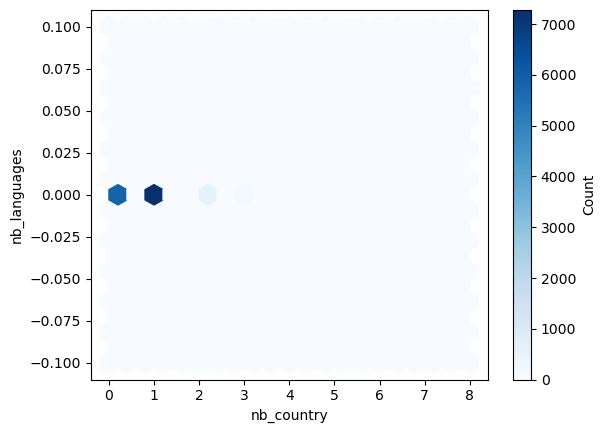

In [83]:
movies_no_language[["nb_languages","nb_country"]]

plt.hexbin(movies_no_language.nb_country,movies_no_language.nb_languages, gridsize=20, cmap='Blues')
plt.colorbar(label='Count')
plt.xlabel('nb_country')
plt.ylabel('nb_languages')
plt.show()

In [84]:
movies_no_language.groupby("nb_country")["nb_country"].agg("count")

nb_country
0    5853
1    7278
2     569
3     131
4      27
5       6
6       2
8       1
Name: nb_country, dtype: int64

The majority of movies with 0 language have 1 or 2 countries 
Movies with 0 countries will be supressed

In [85]:
movies_no_language.loc[movies_no_language['nb_country'] == 1, 'Movie_language']= \
    movies_no_language.loc[movies_no_language['nb_country'] == 1, 'Movie_countries'].copy().apply(
    lambda x: country_language_unique.loc[country_language_unique['Movie_countries'] == x[0],'Movie_language'].values)

movies_no_language.loc[movies_no_language['nb_country'] == 2, 'Movie_language'] = \
    movies_no_language.loc[movies_no_language['nb_country'] == 2, 'Movie_countries'].apply(
        lambda x: country_language_unique.loc[
            (country_language_unique['Movie_countries'] == x[0]) | 
            (country_language_unique['Movie_countries'] == x[1]),
            'Movie_language'
        ].values)

movies_no_language.loc[:, "Movie_language"] = movies_no_language["Movie_language"].apply(lambda x: np.unique(x) if x is not None else x)


movies_no_language.sort_values(by = ["Movie_box_office_revenue"], ascending = False)[["Movie_name", "nb_country","nb_languages","Movie_countries","Movie_language"]][:20]

,Movie_name,nb_country,nb_languages,Movie_countries,Movie_language
49203,Indiana Jones and the Last Crusade,0,0,None,None
62570,Journey 2: The Mysterious Island,1,0,[United States of America],[English ]
4812,The Dictator,0,0,None,None
9339,Contagion,2,0,"[United States of America, United Arab Emirates]",[English ]
18712,Chronicle,0,0,None,None
5571,Barbie: A Fairy Secret,0,0,None,None
13706,To Fly!,1,0,[United States of America],[English ]
71026,On His Majesty's Secret Service,0,0,None,None
15109,The Devil Inside,0,0,None,None
20514,What to Expect When You're Expecting,1,0,[United States of America],[English ]


In [86]:
movies.loc[movies.nb_languages==0] = movies_no_language

# lets upddate the nb of languages
movies.loc[movies.nb_languages==0, "nb_languages"] = movies.loc[movies.nb_languages==0, 'Movie_language'].apply(lambda x: len(x)if x is not None else 0)
print(len(movies.loc[movies.nb_languages==0]))

6030


with this we reduce the number of movies with 0 languages by half

#### 1.2.6 Extracting language and country

Keep only the movies that have 1 or 2 language and 1 or 2 country

In [87]:
movies = movies.loc[(movies.nb_languages <= 2) &(movies.nb_languages > 0) & (movies.nb_country <= 2) & (movies.nb_country >0 )]

Extract and add the 2 main language and 2 main countries for each movie. If the movie only has one main language or main countries, the second value will be "None"

In [88]:
def get_name(list_items):
    if list_items is None: 
        return None, None
    if len(list_items) == 1:
        return list_items[0], None
    elif len(list_items) == 2:
        return list_items[0], list_items[1]
    return None, None



In [89]:
movies[['FirstLanguage_Name', 'SecondLanguage_Name']] = movies['Movie_language'].apply(lambda x: pd.Series(get_name(x)))
movies[['FirstCountry_Name', 'SecondCountry_Name']] = movies['Movie_countries'].apply(lambda x: pd.Series(get_name(x)))

#### 1.2.7 Plots of the final dataset 

Let's look at the 20 most frequently used languages in movies. To do this, we will sum the occurrences of each language as both the first and second language in the data. This gives the total number of movies in which each language appears, meaning that some movies may be counted twice if they contain the language as both primary and secondary.

In [90]:
movies_language1 = movies['FirstLanguage_Name'].dropna().value_counts(ascending=False).reset_index()
movies_language1.columns = ['Language', 'Count']
movies_language1 = movies_language1.set_index('Language')
movies_language2 = movies['SecondLanguage_Name'].dropna().value_counts(ascending=False).reset_index()
movies_language2.columns = ['Language', 'Count']
movies_language2 = movies_language2.set_index('Language').reindex(movies_language1.index, fill_value=0)

merged_languages = movies_language1.merge(movies_language2, left_index=True , right_index=True)
merged_languages["total"] = merged_languages["Count_x"] + merged_languages["Count_y"]
merged_languages = merged_languages.sort_values(by=["total"], ascending = False)


Text(0.5, 1.0, 'Number of movies per language')

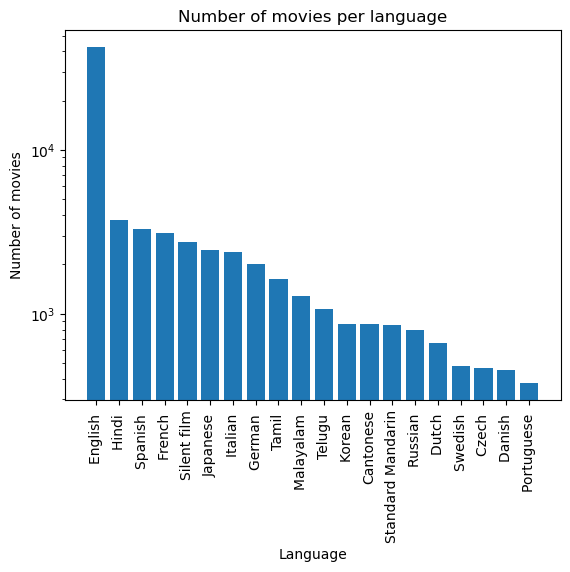

In [91]:

plt.figsize = (15,8)
plt.bar(merged_languages["total"].index[:20],merged_languages["total"][:20])
plt.yscale("log")
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of movies")
plt.xlabel("Language")
plt.title("Number of movies per language")



Now we will do the same for country

In [92]:
movies_country1 = movies['FirstCountry_Name'].dropna().value_counts(ascending=False).reset_index()
movies_country1.columns = ['country', 'Count']
movies_country1 = movies_country1.set_index('country')
movies_country2 = movies['SecondCountry_Name'].dropna().value_counts(ascending=False).reset_index()
movies_country2.columns = ['country', 'Count']
movies_country2 = movies_country2.set_index('country').reindex(movies_country1.index, fill_value=0)

merged_country = movies_country1.merge(movies_country2, left_index=True , right_index=True)
merged_country["total"] = merged_country["Count_x"] + merged_country["Count_y"]
merged_country = merged_country.sort_values(by=["total"], ascending = False)



Text(0.5, 1.0, 'Number of movies per country')

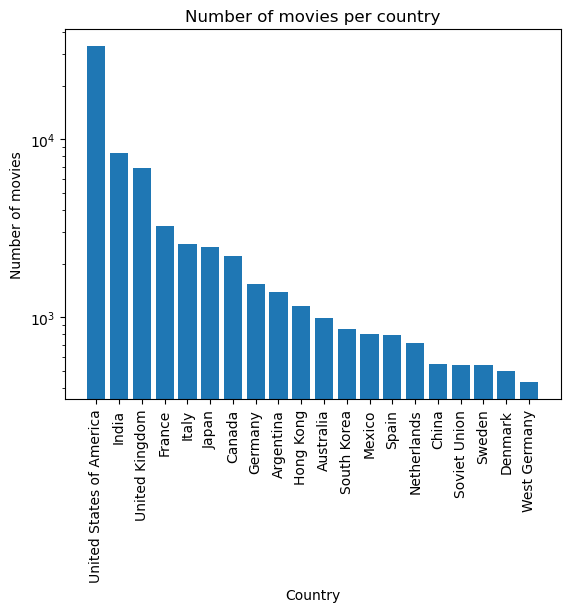

In [93]:
plt.figsize = (15,8)
plt.bar(merged_country["total"].index[:20],merged_country["total"][:20])
plt.yscale("log")
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of movies")
plt.xlabel("Country")
plt.title("Number of movies per country")



### 1.3 Preprocessing and analysis on movies genre

Let's focus now on movies genre, lets see how many genre are attributed to each movie

In [94]:
movies["nb_genre"].describe()

count    71077.000000
mean         3.083628
std          2.104797
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max         17.000000
Name: nb_genre, dtype: float64

Text(0.5, 1.0, 'Number of movies per number of genres')

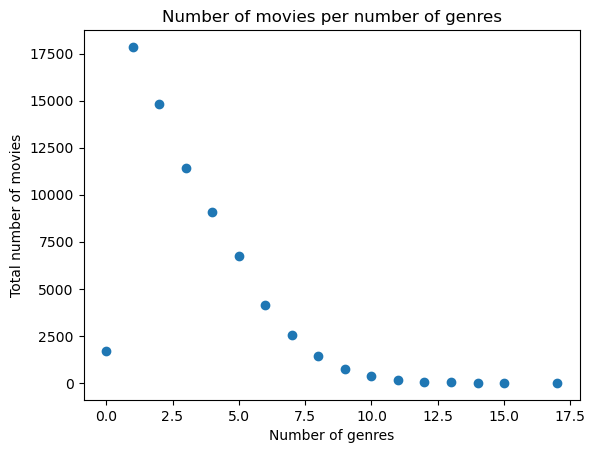

In [95]:
total_genre = movies.groupby("nb_genre")["nb_genre"].agg("count")

plt.figure()
plt.scatter(total_genre.index,total_genre.values)
plt.ylabel("Total number of movies")
plt.xlabel("Number of genres")
plt.title("Number of movies per number of genres")

Text(0.5, 1.0, 'Number of genres per movie')

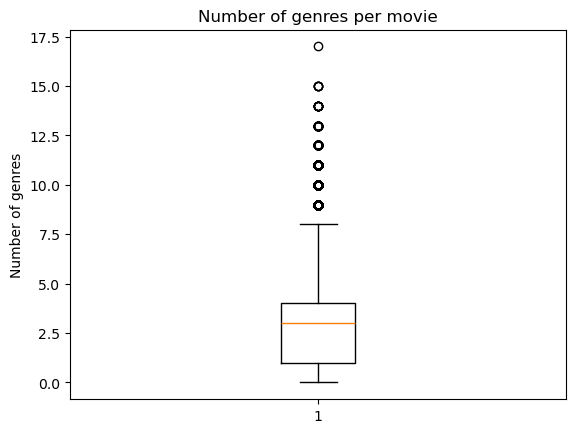

In [96]:
plt.boxplot(movies.nb_genre)
plt.ylabel("Number of genres")
plt.title("Number of genres per movie")

### 1.4 Preprocessing and analysis on movies runtime

In [97]:
print(movies.Movie_runtime.describe())

# number of Nan in Runtime
print()
print("percentage of Nan in  runtime")
movies.Movie_runtime.isnull().sum()/ len(movies.Movie_runtime)

count    5.527700e+04
mean     1.133363e+02
std      4.590700e+03
min      0.000000e+00
25%      8.100000e+01
50%      9.300000e+01
75%      1.060000e+02
max      1.079281e+06
Name: Movie_runtime, dtype: float64

percentage of Nan in  runtime


0.22229413171630766

In [98]:

quantile_5 = np.quantile(movies.Movie_runtime.dropna(), 0.05)
quantile_95 = np.quantile(movies.Movie_runtime.dropna(), 0.95)
print(f" 5% percentiles {quantile_5} minutes and the 95% percentiles {quantile_95} minutes")

 5% percentiles 20.0 minutes and the 95% percentiles 148.0 minutes


the 95 percentile don't seem that long lets, focus on movies whith the highest runtime and other quantiles

In [99]:
movies.sort_values(by = ['Movie_runtime'], ascending = False).head(10)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,nb_languages,nb_country,nb_genre,Movie_language,FirstLanguage_Name,SecondLanguage_Name,FirstCountry_Name,SecondCountry_Name
12804,10815585,/m/02qqy23,Zero Tolerance,1995-01-01 00:00:00+00:00,NaN,1079281.00,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Crime Fiction, Action, Indie, Actio...",1,1,5,[English ],English,None,United States of America,None
71100,25345684,/m/09gqhh3,Cinématon,2011-01-01 00:00:00+00:00,NaN,9360.00,"{""/m/064_8sq"": ""French Language""}",[France],"[Experimental film, Documentary]",1,1,2,[French ],French,None,France,None
21733,14545195,/m/03qcghh,Matrjoschka,2006-04-23 00:00:00+00:00,NaN,5700.00,{},[Germany],"[Indie, Documentary]",1,1,2,[German ],German,None,Germany,None
46666,884435,/m/03lmv2,The Cure for Insomnia,1987-01-31 00:00:00+00:00,NaN,5220.00,"{""/m/02h40lc"": ""English Language""}",[United States of America],[Art film],1,1,1,[English ],English,None,United States of America,None
16316,21689271,/m/05q4cg8,Paradise in Harlem,NaT,NaN,5100.00,{},[United States of America],"[Crime Fiction, Drama]",1,1,2,[English ],English,None,United States of America,None
27036,36136594,/m/0k0ryr0,Kai Koduttha Dheivam,1964-07-18 00:00:00+00:00,NaN,4875.27,"{""/m/07c9s"": ""Tamil Language""}",[India],None,1,1,0,[Tamil ],Tamil,None,India,None
68223,884492,/m/03lm_0,The Longest Most Meaningless Movie in the World,1968-01-01 00:00:00+00:00,NaN,2880.00,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],[Experimental film],1,1,1,[English ],English,None,United Kingdom,None
73658,1348747,/m/04vq_r,Gigantor,1963-10-20 00:00:00+00:00,NaN,2425.00,"{""/m/02h40lc"": ""English Language""}",[Japan],"[Thriller, Science Fiction, Anime, Action, Ani...",1,1,5,[English ],English,None,Japan,None
73630,6012645,/m/0fkkf0,Dil Ne Phir Yaad Kiya,1966-01-01 00:00:00+00:00,NaN,1966.00,"{""/m/03k50"": ""Hindi Language""}",[India],"[Bollywood, World cinema]",1,1,2,[Hindi ],Hindi,None,India,None
30259,884506,/m/03ln0w,The Burning of the Red Lotus Temple,1928-05-13 00:00:00+00:00,NaN,1620.00,{},[China],"[Silent film, Martial Arts Film, Drama]",1,1,3,[Standard Mandarin],Standard Mandarin,None,China,None


The first one of 17 988 hours is actually an error, as no movies of this length exist in the record ( the longest movie ever is of 857 hours) when searching online.

we decided to keep only movies with a length smaller than the 99.5 quantile

In [100]:
quantile_995 = np.quantile(movies.Movie_runtime.dropna(), 0.999)
quantile_995

389.17200000000594

<span style="color:blue"> Je pense qu on peut approfondir cette analyse  et voir ce qu'on enlève en plus du premier outlier </span>

Now lets focus on the short movies of less then 20 minutes


In [101]:
short_movies = movies.loc[((movies.Movie_runtime <quantile_5))]

# check if short film is in the list of genre
sum = 0
for j in short_movies["Movie_genres"]:
    sum += j.count("Short Film")

if sum == len(short_movies):
    print("All movies bellow 20 minutes have a genre short film")

All movies bellow 20 minutes have a genre short film


In [102]:
movies = movies.loc[((movies.Movie_runtime > quantile_5) & (movies.Movie_runtime < quantile_995)) |  (movies.Movie_runtime.isna())]

### 1.5 Preprocessing and analysis on movie revenues

In [103]:
print(movies.Movie_box_office_revenue.describe())

# number of Nan in Runtime
print()
print("percentage of Nan")
movies.Movie_box_office_revenue.isnull().sum()/ len(movies.Movie_box_office_revenue)

count    7.661000e+03
mean     4.831926e+07
std      1.141140e+08
min      1.000000e+04
25%      2.100000e+06
50%      1.060050e+07
75%      4.070800e+07
max      2.782275e+09
Name: Movie_box_office_revenue, dtype: float64

percentage of Nan


0.8876916761955024

 ### 1.6 Preprocessing and anaylisis on movies release year

In [104]:
movies.Movie_release_date.dt.year.describe()

count    64409.000000
mean      1977.556133
std         27.958917
min       1889.000000
25%       1956.000000
50%       1984.000000
75%       2003.000000
max       2016.000000
Name: Movie_release_date, dtype: float64

In [105]:
#percentage of Nan
movies.Movie_release_date.isnull().sum()/ len(movies.Movie_release_date)*100

5.57803383469669

Text(0.5, 1.0, 'Number of movies released per year')

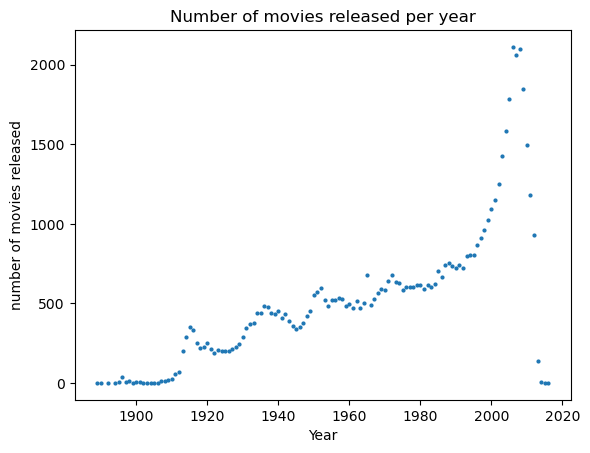

In [106]:
# not cleaned 
yearly_movies = movies.groupby(movies.Movie_release_date.dt.year)['Movie_release_date'].agg('count')
plt.scatter(yearly_movies.index, yearly_movies, s= 4)
plt.ylabel("number of movies released")
plt.xlabel("Year")
plt.title("Number of movies released per year")

Text(0.5, 1.0, 'Movies Language per year')

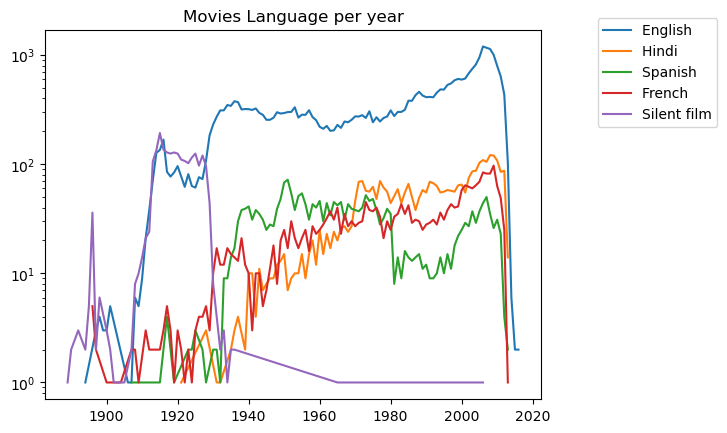

In [107]:

for language in merged_languages.index[:5]:
    movies_language_year = movies.loc[movies.FirstLanguage_Name == language].groupby(movies.Movie_release_date.dt.year)['FirstLanguage_Name'].agg('size')
    plt.plot(movies_language_year, label = language)
    plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Movies Language per year")

Text(0.5, 1.0, 'Movies Language per year')

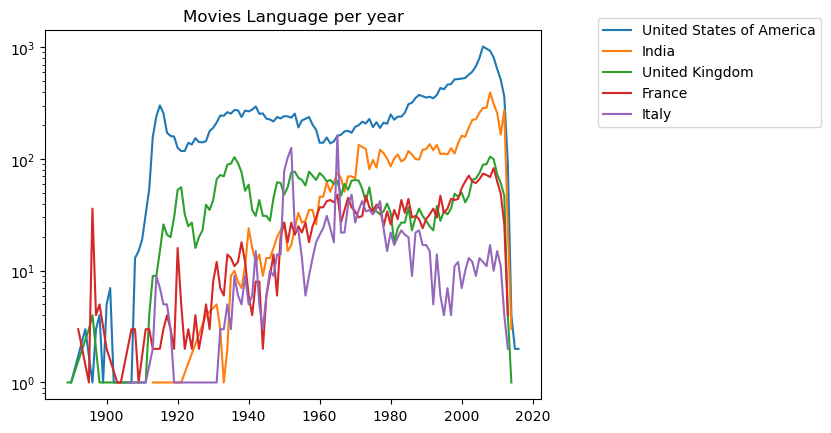

In [108]:
for country in merged_country.index[:5]:
    movies_country_year = movies.loc[movies.FirstCountry_Name == country].groupby(movies.Movie_release_date.dt.year)['FirstCountry_Name'].agg('size')
    plt.plot(movies_country_year, label = country)
    plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Movies Language per year")

### 1.7 Save the new movie dataset 

In [109]:
movies.to_pickle('../../data/movies.pkl')


# 2. TV tropes Dataset preoprocessing

### 2.1 Import and format the dataset

In [110]:
tvtropes = pd.read_csv('../data/tvtropes.clusters.txt', sep="\t", quoting = 3, header = None, on_bad_lines='skip')
tvtropes.columns = ["role", "data"]
parsed_data = tvtropes["data"].apply(lambda x: pd.Series(json.loads(x)))
tvtropes = pd.concat([tvtropes["role"], parsed_data], axis=1)
tvtropes = tvtropes.rename(columns={'char': 'Character_name', 'movie': 'Movie_name','id':'Freebase_character/actor_map_ID','actor':'Actor_name'})

tvtropes.role = tvtropes.role.str.replace('_', ' ')
tvtropes.head()

,role,Character_name,Movie_name,Freebase_character/actor_map_ID,Actor_name
0,absent minded professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent minded professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent minded professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent minded professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent minded professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


### 2.2 Plots to describe the TV tropes dataset

Text(0.5, 1.0, 'Number of characters per role')

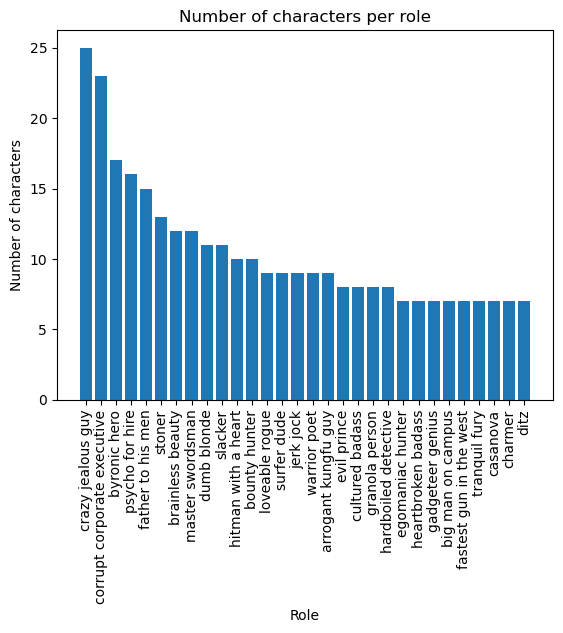

In [111]:
plt.bar( tvtropes.role.value_counts().index[:30], tvtropes.role.value_counts()[:30])
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of characters")
plt.xlabel("Role")
plt.title("Number of characters per role")

Text(0.5, 1.0, 'Number of character appearances in the same role')

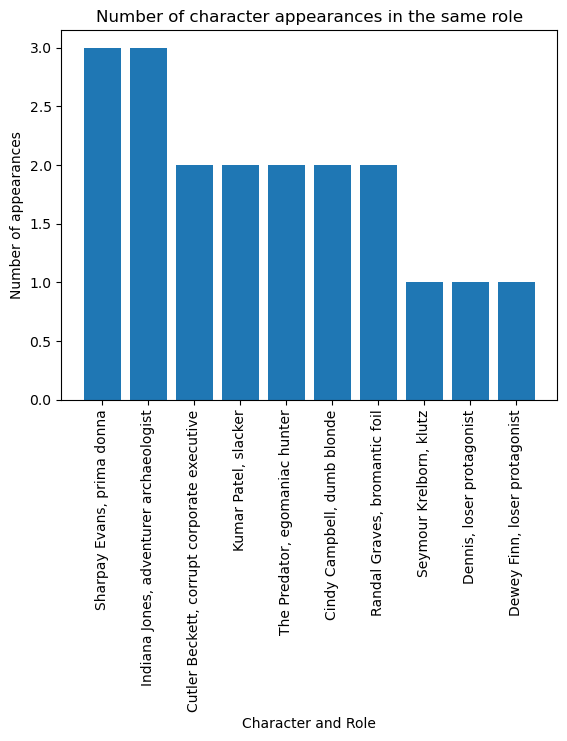

In [112]:
unique_character = tvtropes.drop(['Freebase_character/actor_map_ID','Actor_name','Movie_name'], axis = 1).value_counts()
unique_character = pd.DataFrame(unique_character)
unique_character.reset_index(inplace=True)
#.Role()+ unique_character.Character_name(), unique_character)
plt.bar(unique_character.Character_name[:10]+', '+unique_character.role[:10], unique_character["count"][:10])
plt.xticks(rotation ='vertical',fontsize=10)
plt.ylabel("Number of appearances")
plt.xlabel("Character and Role")
plt.title("Number of character appearances in the same role")

### 2.3 Save TV tropes dataset

In [113]:
tvtropes.to_pickle('../../data/tvtropes.pkl')

# 3 Movie plot dataset preprocessing

### 3.1 Import and format movieplot dataset

In [114]:
summaries = pd.read_csv('../data/plot_summaries.txt', sep="\t", quoting = 3, header = None, on_bad_lines='skip')
summaries.columns = ["Wikipedia_movie_ID", "Plot"]
summaries.head()

,Wikipedia_movie_ID,Plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Some movies have the same plot but different Wikipedia Movie ID : 

In [115]:
plot_duplicate = summaries[summaries.Plot.isin(summaries.Plot.value_counts().index[0:5])]
plot_duplicate

,Wikipedia_movie_ID,Plot
8048,20904516,Raja was adopted by a criminal don at a very ...
10573,14037732,A woman is thrown out of her home by her jealo...
14634,14055212,A woman is thrown out of her home by her jealo...
19678,10791940,Taking a step aside from the usual serious dra...
22056,28852030,"As the American Civil War begins, Ned Burton l..."
29079,25493367,An orphan Raghav turns into a ruthless contrac...
29431,14022275,A woman is thrown out of her home by her jealo...
30990,14051944,A woman is thrown out of her home by her jealo...
31705,14053389,A woman is thrown out of her home by her jealo...
35061,19609453,Raja was adopted by a criminal don at a very ...


It turns out it is movie that have been remade several time accross the years and the plot stays the same. So we can keep them to keep a link with the actors of each movie. 

### 3.2 Merge and save

We can merge this data with the movie dataset and save it

In [116]:
movies_and_plot = pd.merge(left=movies, right=summaries, on='Wikipedia_movie_ID')
movies_and_plot.head()


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,nb_languages,nb_country,nb_genre,Movie_language,FirstLanguage_Name,SecondLanguage_Name,FirstCountry_Name,SecondCountry_Name,Plot
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24 00:00:00+00:00,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",1,1,7,[English ],English,None,United States of America,None,"Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01 00:00:00+00:00,NaN,110.0,"{""/m/02h40lc"": ""English Language""}",[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1,1,3,[English ],English,None,United Kingdom,None,A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01 00:00:00+00:00,NaN,106.0,"{""/m/04306rv"": ""German Language""}",[Germany],[Drama],1,1,1,[German ],German,None,Germany,None,"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01 00:00:00+00:00,NaN,86.0,"{""/m/02h40lc"": ""English Language""}",[South Africa],"[Family Film, Fantasy, Adventure, World cinema]",1,1,4,[English ],English,None,South Africa,None,"Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04 00:00:00+00:00,NaN,93.0,"{""/m/02h40lc"": ""English Language""}",[United States of America],"[Romantic comedy, Ensemble Film, Comedy-drama,...",1,1,7,[English ],English,None,United States of America,None,"Adam, a San Francisco-based artist who works a..."


In [117]:
movies_and_plot.to_pickle('../../data/movies.pkl')